<h1 style=" text-align:center; color:Blue; font-size:40px;"> <u><b>Cat Breeds prediction with InceptionV3</b></u> </h1>

<p style="text-align:center; ">
<img src="https://images.theconversation.com/files/168121/original/file-20170505-1693-ymh4bc.jpg" style='width: 800px;'>
</p>



## 1. Reading Modules


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from scipy import ndimage, misc
import skimage
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout



In [3]:
filelist  = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filelist.append (os.path.join(dirname, filename))
        


In [4]:
len(filelist)

126608

In [5]:
filelist

['/kaggle/input/cat-breeds-dataset/images/Siberian/33225712_366.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/41567870_171.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/38913632_240.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/39745842_209.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/28050949_462.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/23165391_531.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/39212967_231.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/20992970_556.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/42345908_158.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/34203521_344.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/46118853_43695.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/34115903_345.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/37857483_257.jpg',
 '/kaggle/input/cat-breeds-dataset/images/Siberian/18536346_594.jpg',
 '/kaggle/input/ca

### Taking only those 10 labels here.

In [6]:
labels_needed = ['Bombay', 'Calico', 'Burmese', 'Himalayan',
'Munchkin', 'Ragdoll', 'Siberian', 'British Shorthair', 'Russian Blue', 
                 'Dilute Calico']

In [7]:
Filepaths   = []
labels = []

for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    if label in labels_needed:

        Filepaths.append(image_file)
        labels.append(label)
    


In [8]:
set(labels)

{'Bombay',
 'British Shorthair',
 'Burmese',
 'Calico',
 'Dilute Calico',
 'Himalayan',
 'Munchkin',
 'Ragdoll',
 'Russian Blue',
 'Siberian'}

In [9]:
len(Filepaths), len(labels)

(15654, 15654)

### Creating a dataframe with file paths and the labels for them

In [10]:
df = pd.DataFrame( list( zip (Filepaths, labels) ), columns = ['Filepath', 'Labels'] )
df

,Filepath,Labels
0,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
1,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
2,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
3,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
4,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
...,...,...
15649,/kaggle/input/cat-breeds-dataset/images/Bombay...,Bombay
15650,/kaggle/input/cat-breeds-dataset/images/Bombay...,Bombay
15651,/kaggle/input/cat-breeds-dataset/images/Bombay...,Bombay
15652,/kaggle/input/cat-breeds-dataset/images/Bombay...,Bombay


In [11]:
from sklearn.utils import shuffle
df = (df.sample(frac = 1).reset_index()).drop(columns = 'index')
df


,Filepath,Labels
0,/kaggle/input/cat-breeds-dataset/images/Ragdol...,Ragdoll
1,/kaggle/input/cat-breeds-dataset/images/Dilute...,Dilute Calico
2,/kaggle/input/cat-breeds-dataset/images/Calico...,Calico
3,/kaggle/input/cat-breeds-dataset/images/Ragdol...,Ragdoll
4,/kaggle/input/cat-breeds-dataset/images/Russia...,Russian Blue
...,...,...
15649,/kaggle/input/cat-breeds-dataset/images/Calico...,Calico
15650,/kaggle/input/cat-breeds-dataset/images/Munchk...,Munchkin
15651,/kaggle/input/cat-breeds-dataset/images/Russia...,Russian Blue
15652,/kaggle/input/cat-breeds-dataset/images/Calico...,Calico


### Displaying first 12 pictures

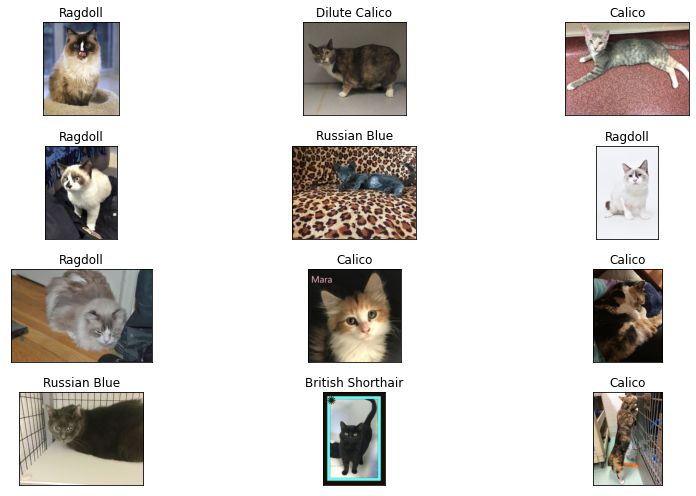

In [12]:
f,a = plt.subplots(nrows=4, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    
plt.tight_layout()
plt.show()

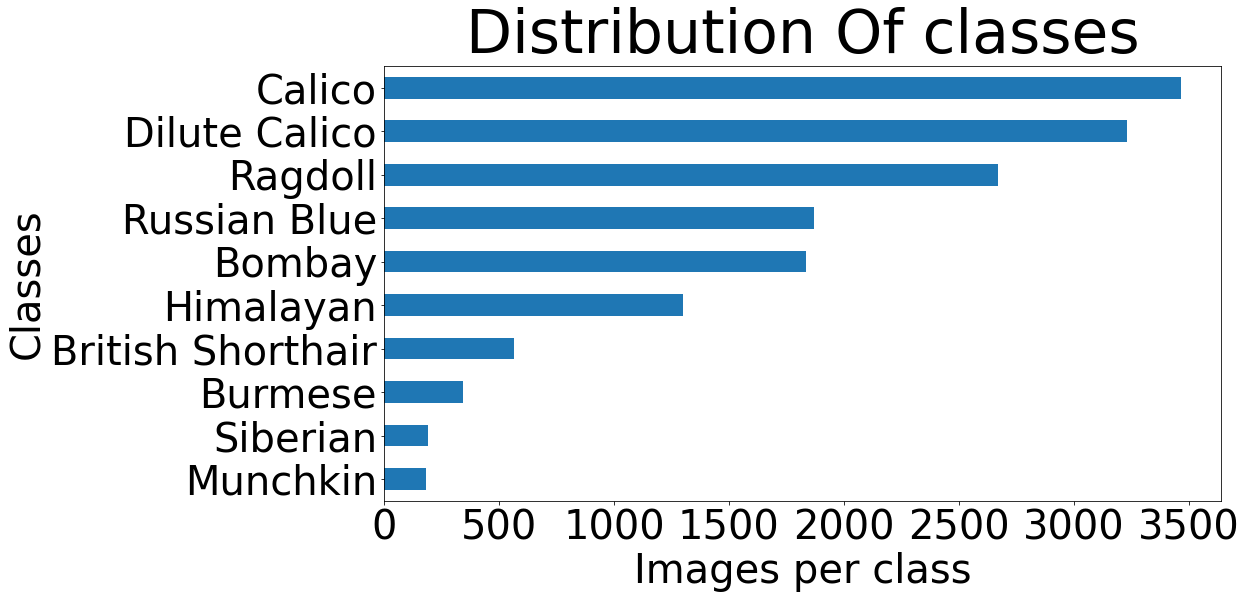

In [13]:
ax=pd.value_counts(df['Labels'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Distribution Of classes",
                                                       figsize=(15,8))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

### Checking for class imbalance

In [14]:
df.Labels.value_counts()

Calico               3468
Dilute Calico        3230
Ragdoll              2669
Russian Blue         1870
Bombay               1835
Himalayan            1301
British Shorthair     567
Burmese               344
Siberian              189
Munchkin              181
Name: Labels, dtype: int64

* Class imbalance present.

### Splitting the data And Creating data generator

In [15]:
train_ratio = .75
validation_ratio = 0.10
test_ratio = 0.25

train, test = train_test_split(df, test_size = test_ratio )
val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio))

In [16]:
img_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
   

x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10)
x_val = img_datagen.flow_from_dataframe(dataframe = val,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10)
x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10)

Found 11740 validated image filenames belonging to 10 classes.
Found 1118 validated image filenames belonging to 10 classes.
Found 2796 validated image filenames belonging to 10 classes.


In [17]:
x_train

### Modelling

In [18]:

i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 0s 0us/step


In [19]:
for layer in i_model.layers:
    layer.trainable = False
    
i_model.summary() 

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
model = Sequential()
model.add(i_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 22,066,346
Trainable params: 263,562
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
model.compile(optimizer = SGD(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [22]:
history = model.fit(x_train, validation_data = x_val,steps_per_epoch = 175,validation_steps = 44,
                epochs = 15, verbose = 2)

Epoch 1/15
175/175 - 67s - loss: 1.6074 - accuracy: 0.4406 - val_loss: 1.2750 - val_accuracy: 0.5773
Epoch 2/15
175/175 - 54s - loss: 1.2435 - accuracy: 0.5583 - val_loss: 1.2112 - val_accuracy: 0.5932
Epoch 3/15
175/175 - 54s - loss: 1.2041 - accuracy: 0.5749 - val_loss: 1.2902 - val_accuracy: 0.5182
Epoch 4/15
175/175 - 52s - loss: 1.1305 - accuracy: 0.5954 - val_loss: 1.1345 - val_accuracy: 0.6205
Epoch 5/15
175/175 - 52s - loss: 1.1267 - accuracy: 0.6017 - val_loss: 1.0850 - val_accuracy: 0.6136
Epoch 6/15
175/175 - 51s - loss: 1.1174 - accuracy: 0.5971 - val_loss: 1.1570 - val_accuracy: 0.6159
Epoch 7/15
175/175 - 49s - loss: 1.0258 - accuracy: 0.6411 - val_loss: 1.0509 - val_accuracy: 0.6682
Epoch 8/15
175/175 - 49s - loss: 1.0260 - accuracy: 0.6309 - val_loss: 1.0798 - val_accuracy: 0.6409
Epoch 9/15
175/175 - 50s - loss: 1.0493 - accuracy: 0.6246 - val_loss: 1.1232 - val_accuracy: 0.6409
Epoch 10/15
175/175 - 50s - loss: 0.9868 - accuracy: 0.6411 - val_loss: 1.0724 - val_accura

### Predicting on test data

In [23]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
predictions

array([8, 3, 0, ..., 3, 7, 3])

In [24]:
labels = x_train.class_indices
labels

{'Bombay': 0,
 'British Shorthair': 1,
 'Burmese': 2,
 'Calico': 3,
 'Dilute Calico': 4,
 'Himalayan': 5,
 'Munchkin': 6,
 'Ragdoll': 7,
 'Russian Blue': 8,
 'Siberian': 9}

In [25]:
test["Labels"].replace({"Bombay": 0,'British Shorthair': 1,
 'Burmese': 2,
 'Calico': 3,
 'Dilute Calico': 4,
 'Himalayan': 5,
 'Munchkin': 6,
 'Ragdoll': 7,
 'Russian Blue': 8,
 'Siberian': 9}, inplace = True)


# Evaluating the test data

## Test Accuracy

In [26]:
test_accuracy = model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

280/280 [==============================] - 59s 210ms/step - loss: 0.9583 - accuracy: 0.6584
Test accuracy is :  65.844064950943 %


## Confusion Matrix

In [27]:
confusion_matrix(test.Labels , predictions)


array([[326,   1,   0,   5,   1,   0,   0,   3,   3,   0],
       [  8,  18,   0,  25,  19,   3,   0,   3,  19,   0],
       [ 19,   1,  11,  11,   2,   4,   0,  10,   3,   0],
       [ 13,   4,   0, 478,  73,   2,   0,   8,   7,   0],
       [  4,   1,   0, 239, 279,   2,   0,  26,  27,   0],
       [  2,   0,   3,  12,   5, 151,   0,  88,   2,   0],
       [  3,   4,   0,  19,   5,   1,   0,   6,   0,   0],
       [  5,   4,   5,  44,  26,  62,   0, 313,   6,   0],
       [ 23,   3,   0,  13,  35,   1,   0,   9, 253,   0],
       [  2,   2,   0,   8,   6,   0,   0,  15,   2,   0]])

## F1 Score

In [28]:
from sklearn.metrics import accuracy_score, f1_score
print('F1 score is',f1_score(test.Labels, predictions, average = 'weighted') *100, "%")


F1 score is 63.3240142985375 %


## ROC - AUC Score

In [29]:
predicted_probab =model.predict_proba(x_test)
predicted_probab

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[1.17749181e-02, 2.53059193e-02, 2.40695417e-01, ...,
        7.42836669e-02, 3.12545568e-01, 8.03042483e-03],
       [6.38897181e-01, 1.04819044e-01, 2.78196540e-02, ...,
        5.02946205e-04, 1.85416520e-01, 3.04181501e-03],
       [9.64677930e-01, 8.72563384e-03, 1.18015939e-02, ...,
        1.13633391e-03, 3.01876711e-03, 1.06972083e-03],
       ...,
       [3.86838652e-02, 5.48397750e-02, 3.26384674e-03, ...,
        2.07081065e-01, 1.81663467e-03, 9.18404479e-03],
       [6.20529463e-04, 5.24738478e-03, 4.68487531e-04, ...,
        8.48831236e-01, 1.31321931e-03, 3.57871279e-02],
       [5.94758755e-03, 4.14536707e-02, 3.36779770e-03, ...,
        2.30027409e-03, 2.44289879e-02, 2.96021742e-03]], dtype=float32)

In [30]:
print("ROC- AUC score is", roc_auc_score( test.Labels, predicted_probab, multi_class='ovr')*100)

ROC- AUC score is 90.48826764106751


# Conclusion

The model is able to classify the images with a roughly 65% accuracy, however, ROC- AUC score goes upto 90.5 %.


## Please do share you feedback and upvote if you likemy work! :)